# Session 1 - idealised merger

In this first session we are going to simulate the interaction between two merging NFW dark matter haloes. The simulations will begin with an idealised set up, before being evolved as an N-body self gravitating system. Through this Summer school we will be using the `SWIFT` simulations code. This session assumes that `SWIFT` is already compiled correct (see folder ?? for details).

The main goals of this first session is to get a basic simulations ran and start to familiarise ourselves with the process, some of the technical details incovled and to start to get a feel for what the outputs of these simulations look like. The key aims are:

 - Generate the idealised inital condition.
 - Run the N-body gravity sim
 - Begin to use and visulaise the outputs
 


Let's begin by importing some moduel that will be useful later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

## Initial conditions

The first thing we need to do is generate the initial conditions (ICs) for the three simuatlions we are about to run. We have provided a simple python script to do this in the `ICs` folder. Running the following in your terminal should generate the necesarry ICs:
```
cd ICs
python3 Gen_ICs.py
```
Hopefully now there are three new files within that directory, `ICs_isolate_host.hdf5`, `ICs_isolate_satellite.hdf5` and `ICs_merger.hdf5`. These are the three inita conditions we will be using. Here we have also now been introduced to a key (potentially) new gile type, HDF5. HDF5 files are specifically designed to efficeintly store and access large amounts of data, and as such are the most widely used file type for cosmological simualations, bith inputs and outputs.

To start with let's have a quick look at what the ICs look like.

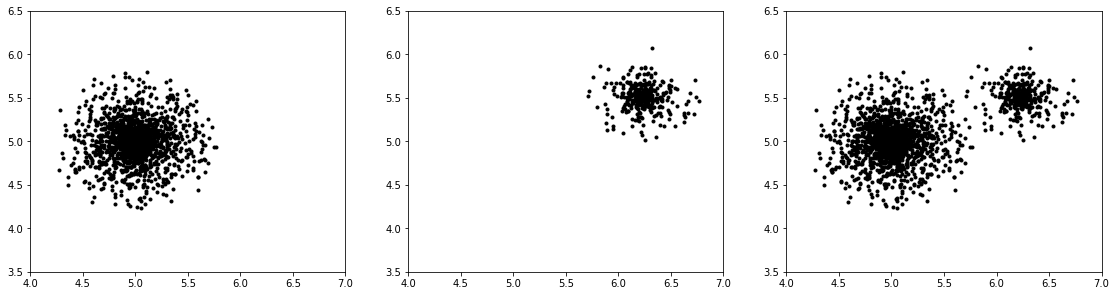

In [2]:
file_names = ['./ICs/ICs_isolated_host.hdf5','./ICs/ICs_isolated_satellite.hdf5','./ICs/ICs_merger.hdf5']

fig, ax = plt.subplots(1,3,figsize=(6.4*3,4.8))
for i in range(3):
    h = h5.File(file_names[i],'r') #read hdf5 file
    pos = h['PartType1/Coordinates']
                
    ax[i].plot(pos[:,0],pos[:,1],'k.')
    ax[i].set_xlim(4,7)
    ax[i].set_ylim(3.5,6.5)

The three different ICs represent the host on it's own (left), the mergeing satellite on its own (middle), and the two systems modelled together (right). Both systems are assumed to have NFW profiles, with the host being a 10^12 M_sun masses DM halo, with a concentration of 6. While the merging system is a 10^11.5 halo with a concentration of 15. In terms of mass these systems are similar to the ongoing merger between our Milky Way and the Large Magalanic cloud. 

Assuming and NFW profile specifies the positions of the particles. But we must also provide velocities. These are generated so that each system is in equilibrium, according to the Jeans equation. For those interested in how to generate these ICs you have have a look a the `Gen_ICs.py` script or just ask. However, it isn't important for the main goals of this session

## Running the simulations

Now that we have generated the initial conditions we can run the simulations. In the working directory for this session there is a SWIFT parameter file set up to run the host halo in isolation, `parameter_isolated_host.yml`, with a submission script to set the simulation running. Typing the following in the command line should then run the simulation,
`
./submit.sh
`
Hopefully this outputs a bunch of numbers to the comand line that summarise how the simualtion is progressing, listing information such as the number of time steps, the current time, and the time step being used. The current simulation is set to run for 10 Myr, so will finfish when the second column reads 1e-2 in internal units. This will take roughly a minute in wall clock time.

The simualtions will finish with the line '... main: done. Bye.'. We can then check that the outputs files look reasonable. Type `ls dir_isolated_host`, this should output a bunch of file that read `output_0*.hdhf`. These are known as simulation snapshots, and are outputs of all the particles in the simulation and their associated properties for a range of times. Generally, it is too expenseive to output the information at every time step, hence we output this at spefic times. Generally the number of snapshots for a cosmolgical simualtiosn will range from tens to a few hundred.

Now we need to run two more simulations. One with the satelite in isolate, and the more interesting simuatlison where the host and satellite can interact. You therefore need to create new paramter files and submission scripts to run these simulations. The main things that will need to be changed are the IC files, ` ICs_isolated_satellite.hdf5` and ` ICs_merger.hdf5`, and the output directory so that the simulations we have just ra is not overwritten. In this notebook example we are going to output the simulations in the directories `dir_isolated_sat` and `dir_merger`, though any name can be used.

## Analysing the simulations

Now that the simulations ave been ran we can start to analyse the results. Let's start by making sure we can read in the snapshot data.

In [3]:
loc = './dir_isolated_host/output_0000.hdf5'
h = h5.File(loc,'r')

We can then have a look at the data availiable in the snapshot.

In [4]:
print(h.keys())

<KeysViewHDF5 ['Cells', 'Code', 'Cosmology', 'DMParticles', 'GravityScheme', 'Header', 'InternalCodeUnits', 'Parameters', 'PartType1', 'PhysicalConstants', 'Policy', 'RecordingTriggers', 'SubgridScheme', 'Units', 'UnusedParameters']>


Here we ca see that there are a lot of different groups in the snapshot files. A lot of this is general and technical information about the simulations. The simulation data itself will generally be in `PartType*`. Here we have run a DM only simuatlion, so it the data we want is in `PartType1`. 

In [5]:
print(h['PartType1'].keys())

<KeysViewHDF5 ['Coordinates', 'Masses', 'ParticleIDs', 'Potentials', 'Softenings', 'Velocities']>


Here there are six properties stored for each DM particle (the number will change for each particle type). Here let's have a quick look at the position of the particles (Coordinates) to make sure that the ICs have been read correctly.

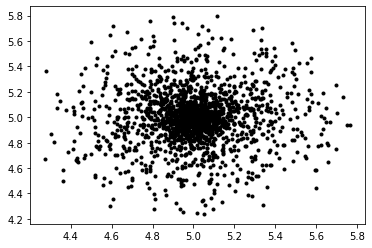

In [6]:
pos = h['PartType1']['Coordinates']
                     
plt.plot(pos[:,0],pos[:,1],'k.')

We can now start to look at the time evolutino of the system. We'll start by looking at the two isoalted cases to get a feel for the dynamics without them interacting.

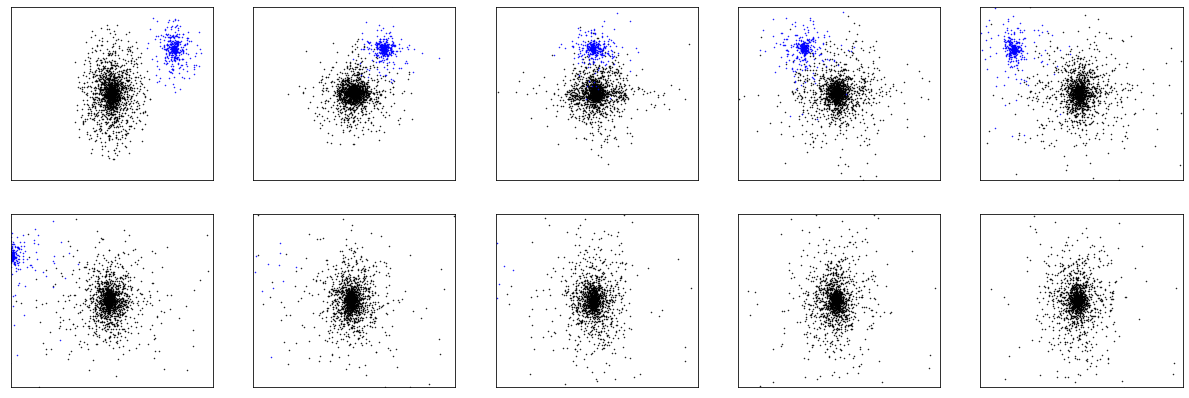

In [7]:
num_snap = 50 #maximum snapshot to use
step = 5
pos_host = []
pos_sat = []

i = 0
while i<=num_snap:
    h_host = h5.File('./dir_isolated_host/output_%04d.hdf5'%i,'r')
    h_sat = h5.File('./dir_isolated_sat/output_%04d.hdf5'%i,'r')
    
    pos_host.append(h_host['PartType1']['Coordinates'])
    pos_sat.append(h_sat['PartType1']['Coordinates'])
    i+=step

#now lets plot, with host in black and satellite in blue
fig,ax = plt.subplots(2,int(num_snap/(step*2)),figsize=(12*1.75,4*1.75))
k=0
for i in range(2):
    for j in range(int(num_snap/(step*2))):
        ax[i,j].plot(pos_host[k][:,0],pos_host[k][:,1],'k.',markersize=1)
        ax[i,j].plot(pos_sat[k][:,0],pos_sat[k][:,1],'b.',markersize=1)
        
        #remove ticks
        ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
        #set x and y limits
        ax[i,j].set_xlim(3,7)
        ax[i,j].set_ylim(4,6)
        k+=1

The general set up of the system is for the satellite to be thrown towards the host, slightly offset from head on. In this set up where they do not interact they simply fly past each other. The other noticeable feature is that the edges of each halo appear to 'puff up'. This due to the ICs being genrated with a sharp cut off, the system therefore slighty readjusts at the start, with a small number of particles essentially thrown out due to their specific, randomly assigned, velocities. Though the halo as a whole is stable.

Let's now make the same plot but for when the two systems interacts. Here we need to be able to identify particles as belonging to the host and the satellite. In the previous plot this was trivial as they wre seperate simuatlions. Here we can use the particle IDs to do this. Each particle is assigned a unique ID so that it an be tracked between snapshots. For these particular ICs the Particle IDs are order so that the first N particles are the host (in this set up the host has 2074 particles), and the rest belong to the satellite.

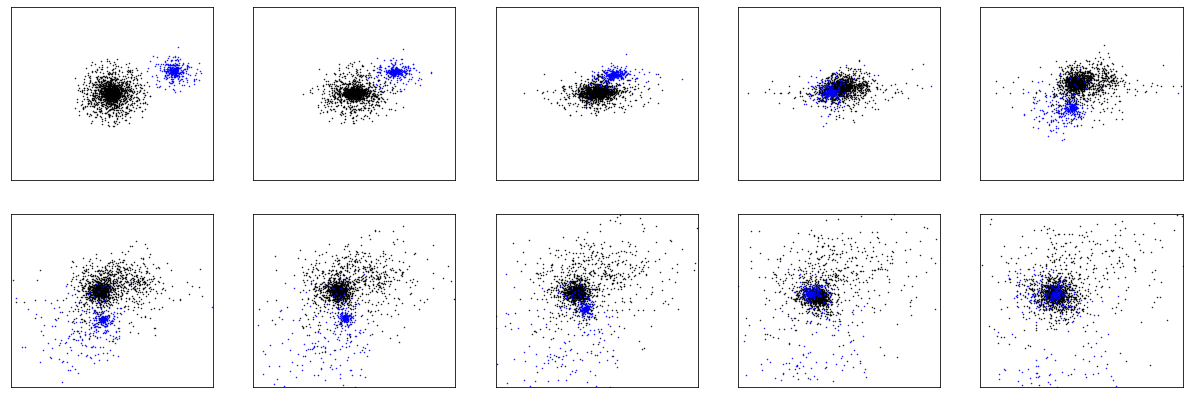

In [8]:
N_host = 2074
num_snap = 30 #maximum snapshot to use
step = 3
pos = []
part_ID = []
i = 0
while i<=num_snap:
    h = h5.File('./dir_merger/output_%04d.hdf5'%i,'r')
    
    pos.append(np.array(h.get('PartType1/Coordinates')))
    part_ID.append(np.array(h.get('PartType1/ParticleIDs')))
    i+=step

#now lets plot, with host in black and satellite in blue
fig,ax = plt.subplots(2,int(num_snap/(step*2)),figsize=(12*1.75,4*1.75))
k=0
for i in range(2):
    for j in range(int(num_snap/(step*2))):
        cut_host = part_ID[k]<N_host
        ax[i,j].plot(pos[k][cut_host,0],pos[k][cut_host,1],'k.',markersize=1)
        ax[i,j].plot(pos[k][np.invert(cut_host),0],pos[k][np.invert(cut_host),1],'b.',markersize=1)

        #remove ticks
        ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
        #set x and y limits
        ax[i,j].set_xlim(3,7)
        ax[i,j].set_ylim(3,7)
        k+=1

Here we can see clear interactions between the two haloes now. The satellite initially falls towards the host halo, before being slingshot around and eventually falling back into the host where it is fully merged with the host.

We can also plot the orbit of the satellite.

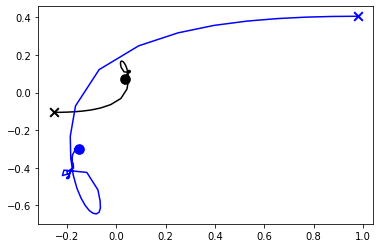

In [9]:
# we'll now loop over each snapshot up to a maximum snapshots that we have to plot the cntre of mass of both the host and satellite
num_snaps = 50

com_host = np.zeros((num_snaps,3))
com_sat = np.zeros((num_snaps,3))
com_tot = np.zeros((num_snaps,3))
for i in range(num_snaps):
    h = h5.File('./dir_merger/output_%04d.hdf5'%i,'r')
    pos = np.array(h['PartType1/Coordinates'])
    part_ID = np.array(h['PartType1/ParticleIDs'])
    com_host[i,:] = np.mean(pos[part_ID<N_host],axis=0)
    com_sat[i,:] = np.mean(pos[part_ID>=N_host],axis=0)
    com_tot[i,:] = np.mean(pos,axis=0)

#plot orbit tracks
plt.plot(com_host[:,0]-com_tot[:,0],com_host[:,1]-com_tot[:,1],'k-')
plt.plot(com_sat[:,0]-com_tot[:,0],com_sat[:,1]-com_tot[:,1],'b-')

#plot start with x, and end with circle
plt.scatter(com_host[0,0]-com_tot[0,0],com_host[0,1]-com_tot[0,1],marker='x',s=75,linewidths=2,color='black')
plt.scatter(com_sat[0,0]-com_tot[0,0],com_sat[0,1]-com_tot[0,1],marker='x',s=75,linewidths=2,color='blue')

plt.scatter(com_host[-1,0]-com_tot[-1,0],com_host[-1,1]-com_tot[-1,1],marker='o',s=75,linewidths=2,color='black')
plt.scatter(com_sat[-1,0]-com_tot[-1,0],com_sat[-1,1]-com_tot[-1,1],marker='o',s=75,linewidths=2,color='blue')

Need to explain this plot!!!!

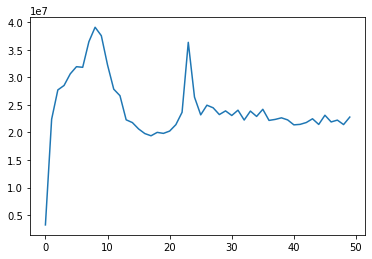

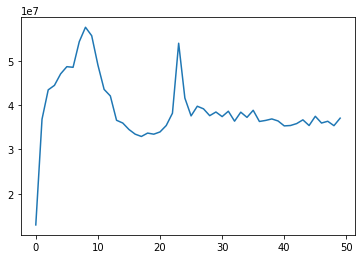

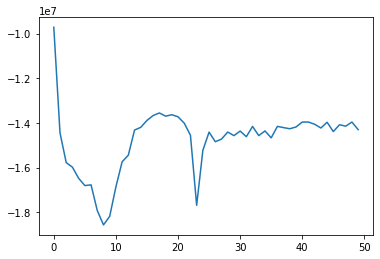

In [10]:
#let's calucalte the energy of each component
KE_tot = np.zeros(num_snaps)
KE_host = np.zeros(num_snaps)
KE_sat = np.zeros(num_snaps)

PE_tot = np.zeros(num_snaps)
PE_host = np.zeros(num_snaps)
PE_sat = np.zeros(num_snaps)

for i in range(num_snaps):
    h = h5.File('./dir_merger/output_%04d.hdf5'%i,'r')
    vel = np.array(h['PartType1/Velocities'])
    pot = np.array(h['PartType1/Potentials'])
    mass = np.array(h['PartType1/Masses'])[0] #here we have constant mass
    part_ID = np.array(h['PartType1/ParticleIDs'])
    cut_host = part_ID[k]<N_host
    
    KE_tot[i] = 0.5*np.sum(vel**2)
    KE_host[i] = 0.5*np.sum(vel[cut_host,:]**2)
    KE_sat[i] = 0.5*np.sum(vel[np.invert(cut_host),:]**2)
    
    PE_tot[i] = np.sum(pot)*mass
    PE_host[i] = np.sum(pot[cut_host])
    PE_sat[i] = np.sum(pot[np.invert(cut_host)])

    
#check fot energy conservation
plt.figure()
plt.plot(np.arange(num_snaps),(PE_tot+KE_tot))

plt.figure()
plt.plot(np.arange(num_snaps),KE_tot)

plt.figure()
plt.plot(np.arange(num_snaps),PE_tot)